# Chapter 2: End-to-End Machine Learning Project

First we work with a relatively simple dataset and go through the full Machine Learning process


*   Explore
*   Clean
*   Train
*   Tune



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Collect Data

In [2]:
housing = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv", sep=",")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(housing, test_size=.2, random_state=42)

length = 'Length of {0} set is {1}'

print(length.format('train', len(train)))
print(length.format('test', len(test)))

Length of train set is 16512
Length of test set is 4128


# Explore

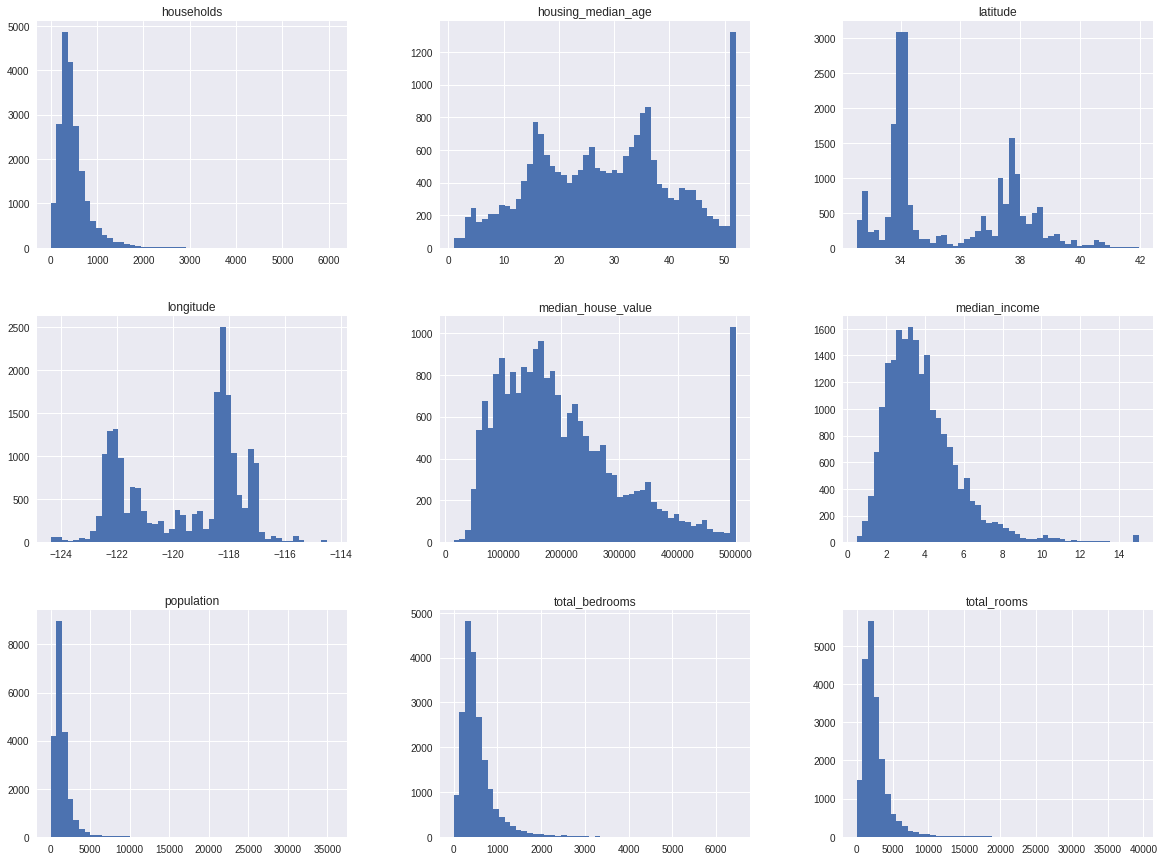

In [0]:
#View distributions of Numeric features

ax = housing.hist(bins=50, figsize=(20,15))

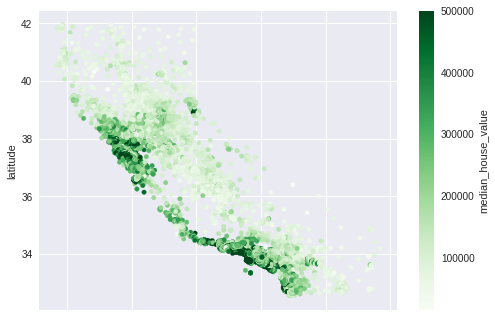

In [0]:
#Plot and look for correlations between location and median price

_ = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=1, c='median_house_value', cmap=plt.get_cmap('Greens'))

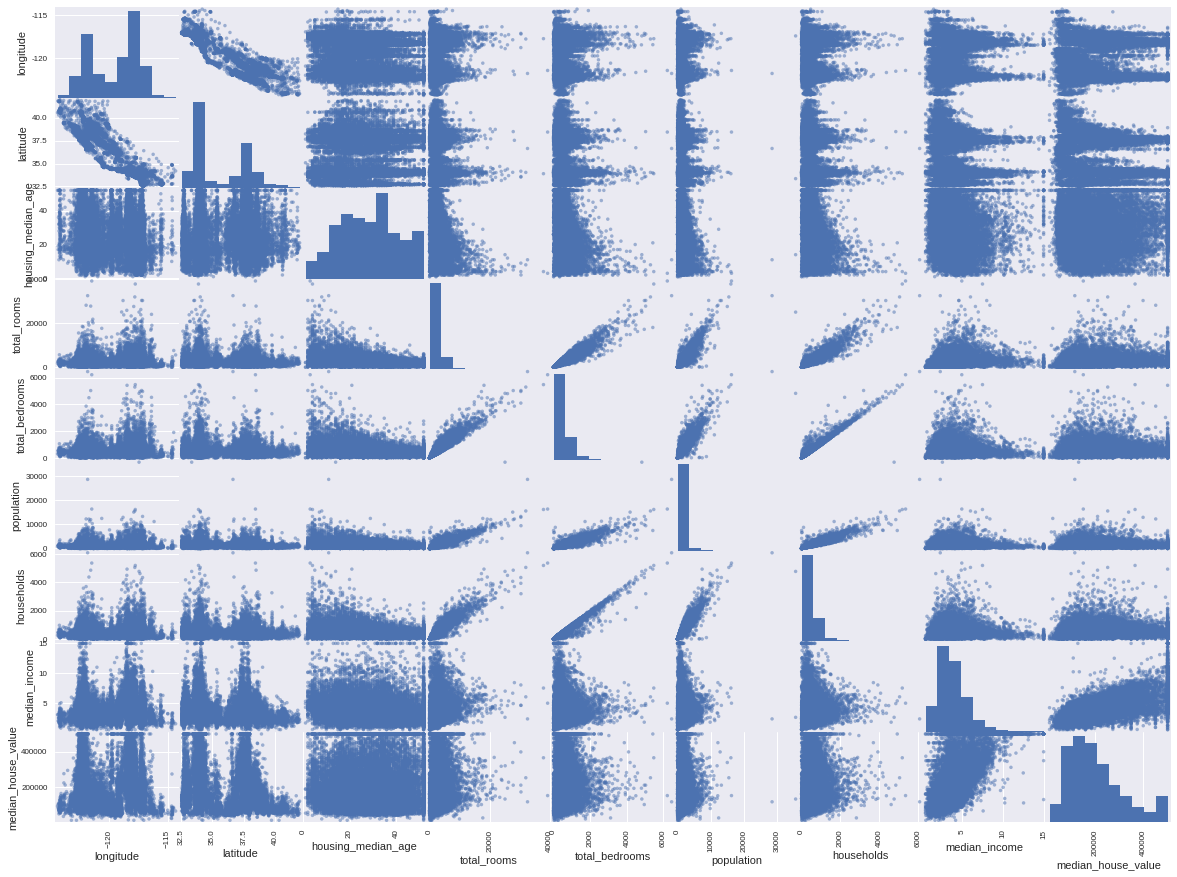

In [0]:
#View correlations between features

from pandas.plotting import scatter_matrix

_ = scatter_matrix(housing[housing.columns[:-1]], figsize=(20,15))

# Clean

Below we can see missing data in the 'total_bedrooms' feature. There is also a Categorical column. Build a pipeline to process this data properly.

In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [0]:
#Custom 'transformer' to filter columns from the DataFrame as needed

from sklearn.base import BaseEstimator, TransformerMixin

class FilterColumns(BaseEstimator, TransformerMixin):
  def __init__(self, features):
    self.features = features
   
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    return X[self.features].values

In [0]:
#Build a pipeline for numeric and categorical data
#Combine the cleaned fields into a final prepared dataset

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

num_features = ['longitude','latitude','median_income','households', 'total_bedrooms']
cat_features = ['ocean_proximity']

num = Pipeline([
    ('filter', FilterColumns(num_features)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat = Pipeline([
    ('filter', FilterColumns(cat_features)),
    ('encoder', OneHotEncoder(sparse=False))
])

full = FeatureUnion(transformer_list=[
    ('num_pipe', num),
    ('cat_pipe', cat)
])

In [6]:
#Process data

train_cleaned = pd.DataFrame(full.fit_transform(train), columns=num_features + list(cat.named_steps['encoder'].categories_[0]))
train_cleaned.head()

,longitude,latitude,median_income,households,total_bedrooms,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1.272587,-1.372811,-0.326196,0.322906,0.211228,0.0,0.0,0.0,0.0,1.0
1,0.709162,-0.876696,-0.035843,0.672027,0.593094,0.0,0.0,0.0,0.0,1.0
2,-0.447603,-0.460146,0.144701,-0.430461,-0.495226,0.0,0.0,0.0,0.0,1.0
3,1.232698,-1.382172,-1.017864,-0.380587,-0.409306,0.0,0.0,0.0,0.0,1.0
4,-0.108551,0.532084,-0.171488,-0.314962,-0.256559,0.0,1.0,0.0,0.0,0.0


# Train and Test Model

In [14]:
#Train Model

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

parameters = {
    'kernel' : ('linear', 'rbf','poly'), 
    'C' : np.arange(.01, 15, 30),
    'gamma' : np.arange(.01,15,30)
}

model = RandomizedSearchCV(SVR(), parameters, cv=5, n_iter=20, scoring=make_scorer(mean_squared_error))
model.fit(train_cleaned, train['median_house_value'])

final = model.best_estimator_

print('Best score was {0}'.format(model.best_score_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 3 is smaller than n_iter=20. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best score was 14112131584.506575


In [18]:
#Measure performance on test data 
test_cleaned = pd.DataFrame(full.fit_transform(test), columns=num_features + list(cat.named_steps['encoder'].categories_[0]))
print('Test data performance is {0}'.format(model.score(test_cleaned, test['median_house_value'])))

Test data performance is 13762026844.728865
